(only tesed on Python 3.6)

this notebook shows how to use the stereo module in leelab toolbox to handle CMU stereo dataset.

In [1]:
# change `inline` to `notebook` if you want to rotate the 3D plot.
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os.path
from leelabtoolbox.stereo import io as stereo_io, conversion as stereo_conversion
from copy import copy

In [2]:
example_scene_file = os.path.join('..','tests','stereo_ref','cmu','04.mat')
scene_struct = stereo_io.cmu_raw_to_retina2_sph(stereo_io.read_cmu_range_image_database(example_scene_file))

In [3]:
# number of bad points. very few.
scene_struct['mask'].sum(), scene_struct['degree_per_pixel_horizontal'], scene_struct['degree_per_pixel_vertical']

(35765, 0.039971274715300056, 0.039979667901586982)

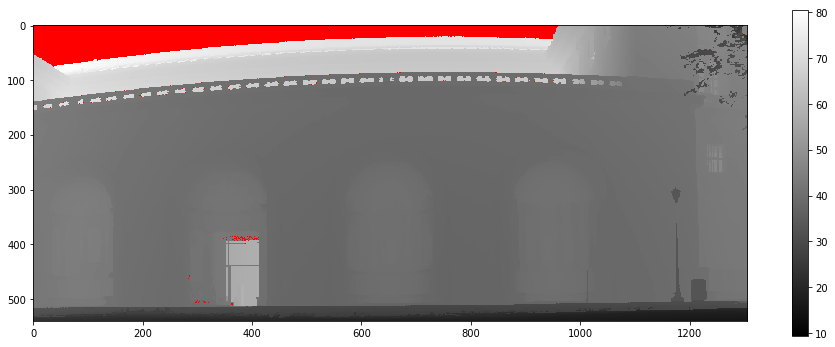

9.273 80.5


In [4]:
distance_mask = scene_struct['mask']
distance = scene_struct['distance'].copy()
distance[distance_mask]=np.nan
cmap=copy(matplotlib.cm.gray)
# set nan to red
# <https://stackoverflow.com/questions/2578752/how-can-i-plot-nan-values-as-a-special-color-with-imshow-in-matplotlib>
# <https://stackoverflow.com/questions/35905393/python-leave-numpy-nan-values-from-matplotlib-heatmap-and-its-legend>
cmap.set_bad('red')
# show the range map
plt.close('all')
plt.figure(figsize=(16, 6))
plt.imshow(distance, cmap=cmap)
plt.colorbar()
plt.show()
print(np.nanmin(distance), np.nanmax(distance))

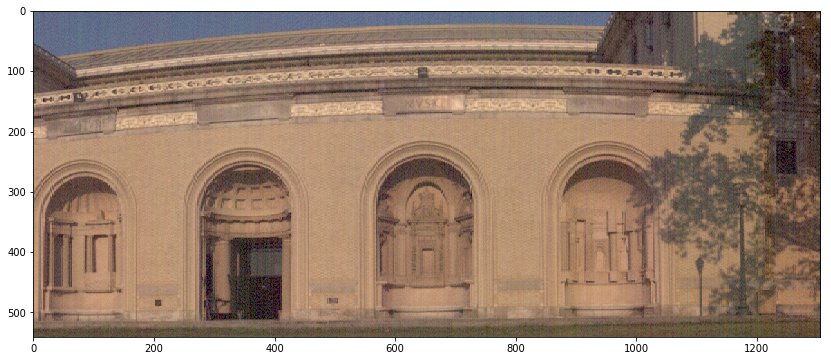

In [5]:
# show color image
color_image = scene_struct['optical_image']
color_image /= color_image.max()
# gamma correction.
color_image**=0.5
color_image = (color_image*255) .astype(np.uint8)
plt.close('all')
plt.figure(figsize=(16, 6))
plt.imshow(color_image)
plt.show()

In [6]:
# then convert to xyz.
valid_mask = np.logical_not(distance_mask)
xyz_valid = stereo_conversion.sph2cart(scene_struct['distance'][valid_mask],
                                       scene_struct['latitude'][valid_mask],
                                       scene_struct['longitude'][valid_mask], convention='retina2')
xyz_all = np.full((3,)+valid_mask.shape, fill_value=np.nan, dtype=np.float64)
xyz_all[:,valid_mask] = xyz_valid
# whether multiply by 2 or not for 'bearing':
# if you use the below one, where we don't multiply by 2 for bearing in Brown, and if you pan over the below 3D plot,
# you will that it makes no sense.

# xyz_valid = stereo_conversion.sph2cart(scene_struct_2['distance'][valid_mask],
#                                        scene_struct_2['latitude'][valid_mask],
#                                        scene_struct_2['longitude'][valid_mask], convention='retina2')

# whether the unit of inclination is correct.
# based on printed out values below, you can see that this the camera is surrounded by the captured scene, and you 
# can find points behind camera (positive z) as well.
# based on panning the below 3D plot, it seems that unit of inclination is correct.

print(xyz_valid.z.min(), xyz_valid.z.max())
print(np.nanmin(scene_struct['longitude']), np.nanmax(scene_struct['longitude']))

-70.7230773098 -8.73757430025
-0.445589351143 0.465943757296


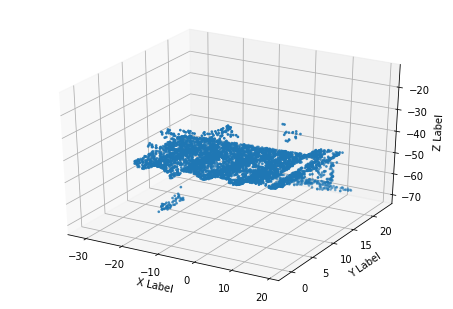

In [7]:
from mpl_toolkits.mplot3d import Axes3D

# randomly sample 30000 points.
rng_state = np.random.RandomState(seed=0)
xyz_valid = np.asarray(xyz_valid)
xyz_valid_reduced = xyz_valid[:, rng_state.choice(xyz_valid.shape[1], 5000)]
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(*xyz_valid_reduced, s=3)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

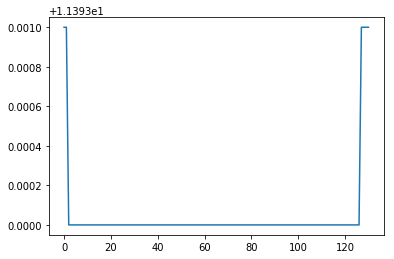

In [8]:
# somehow, this doesn't work with `%matplotlib notebook`. just comment it when using notebook mode.
plt.plot((scene_struct['latitude'][200,::10]*180/np.pi))
plt.show()

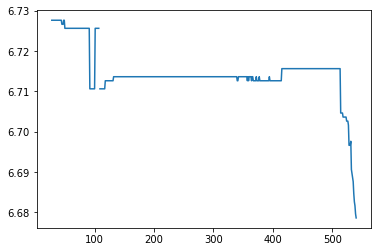

In [9]:
plt.plot((scene_struct['longitude'][:, 500]*180/np.pi))
plt.show()

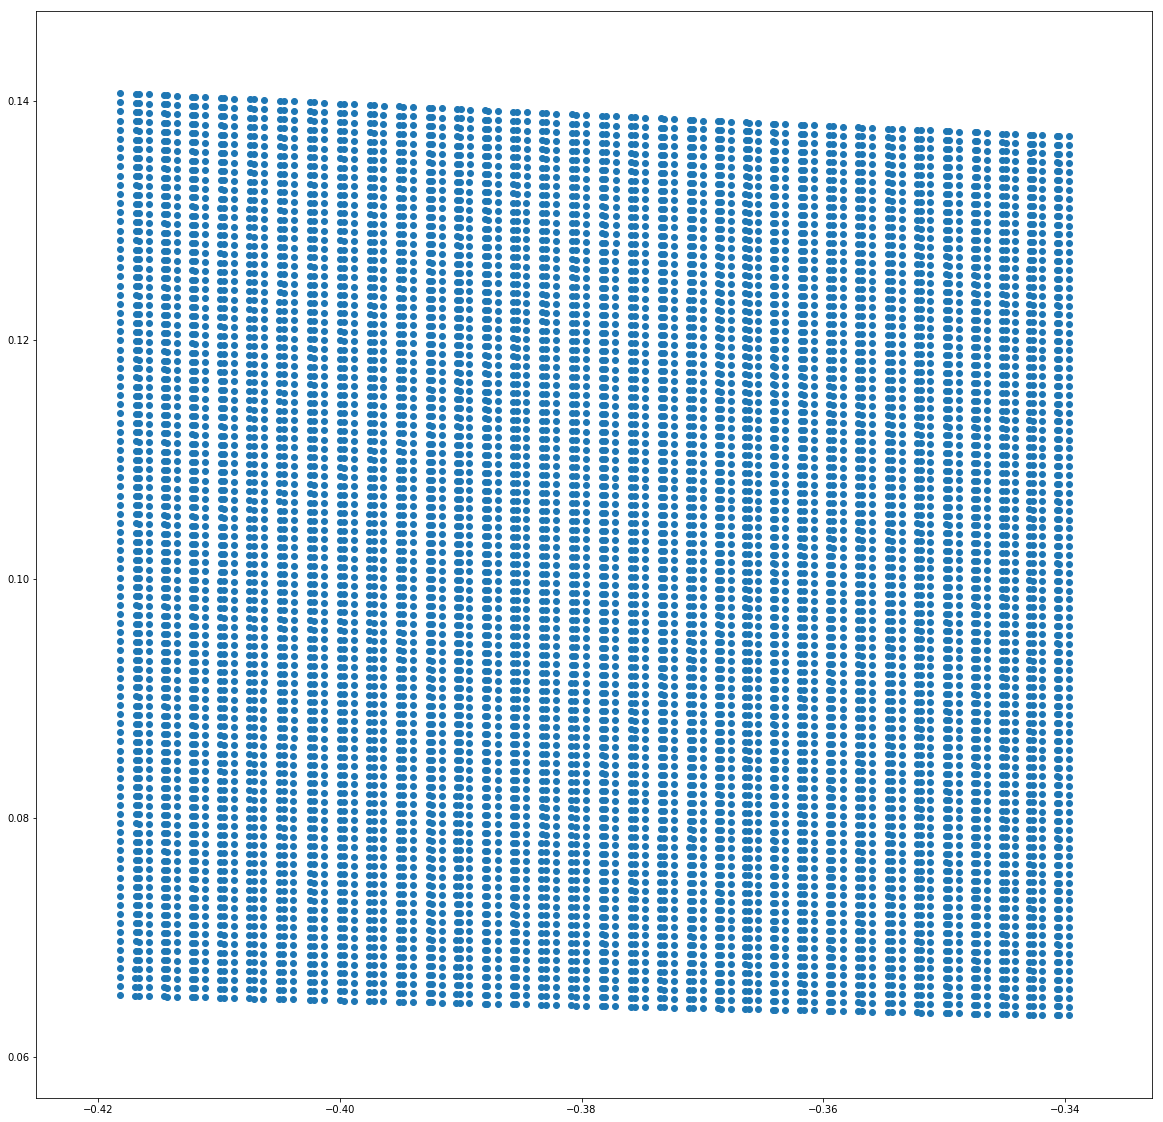

In [10]:
selector = slice(300,400), slice(100,200)
x_new, y_new, z_new = xyz_all[(slice(None),)+selector].copy()
# then normalize x, y according to z.
assert np.all(z_new < 0)
# then compute z's normal for each pixel
x_new/=-z_new
y_new/=-z_new
z_new/=-z_new
assert np.allclose(z_new, -1, atol=1e-3)
plt.close('all')
plt.figure(figsize=(20,20))
plt.scatter(x_new.ravel(), y_new.ravel())
plt.show()

# definitely, this range finder is not uniform in Cartesian system.
# maybe so in spheretical system.

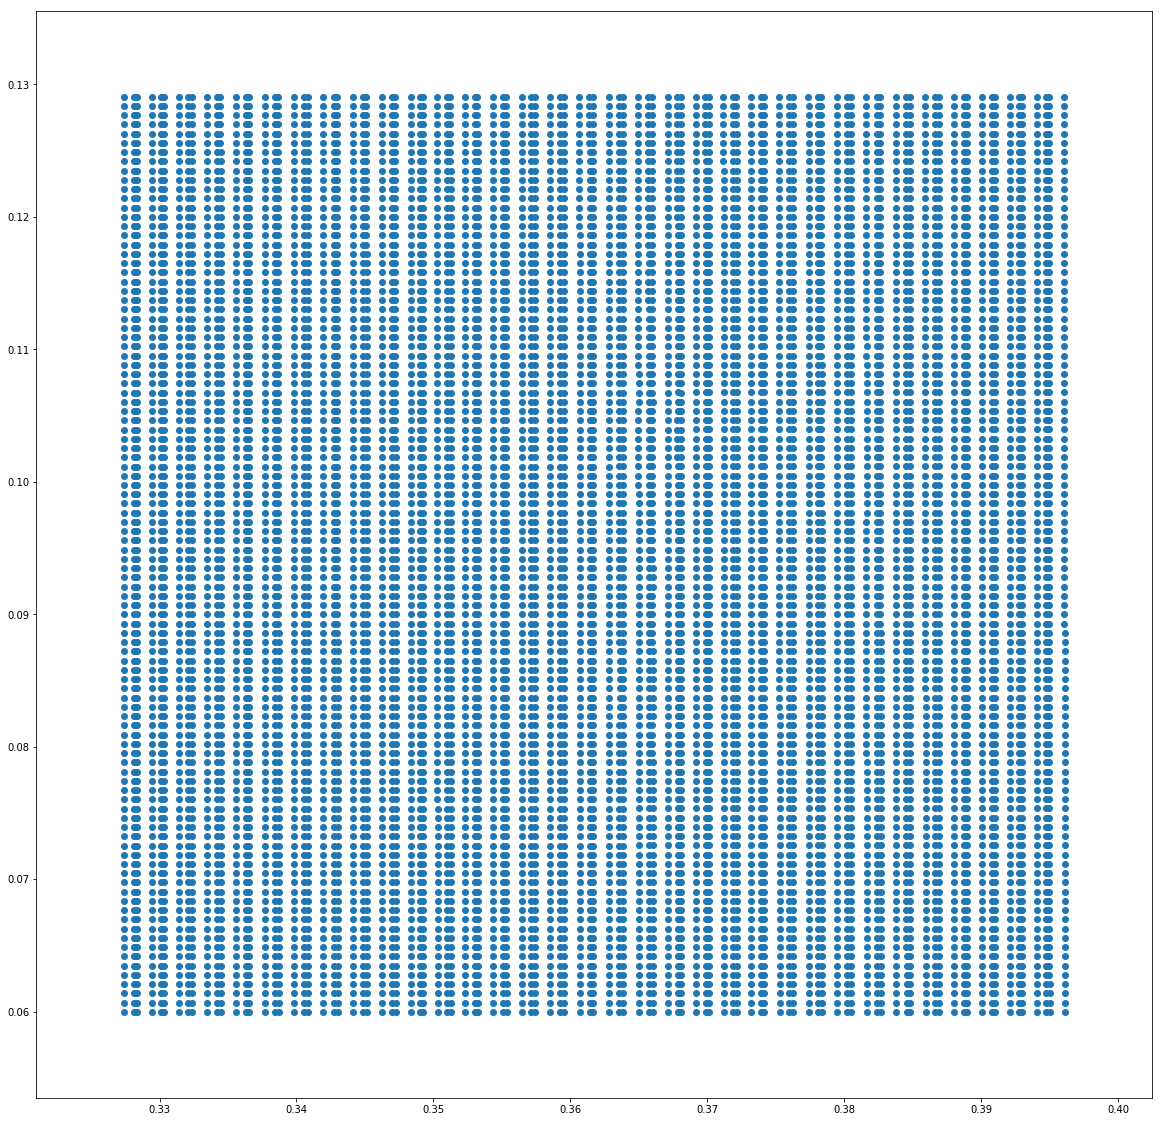

In [11]:
plt.close('all')
plt.figure(figsize=(20,20))
plt.scatter(scene_struct['longitude'][selector].ravel(), scene_struct['latitude'][selector].ravel())
plt.show()
# in deed, roughly so.